<a href="https://colab.research.google.com/github/parimalakettymuthu/MachineLearning-Projects/blob/main/MultiLabel_Classification_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys 
#sys.path.append('/content/drive/MyDrive/NLP/custom-functions')

In [3]:
import pandas as pd
from pathlib import Path
import joblib
# Importing the necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchtext.vocab import  vocab

import random
import numpy as np
import pandas as pd
import joblib
from collections import Counter


from pathlib import Path
import sys

from sklearn.model_selection import train_test_split
!pip install wandb -qq
import wandb

In [4]:
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  drive.mount('/content/drive')   
  base_path = '/content/drive/MyDrive/NLP'
  sys.path.append('/content/drive/MyDrive/NLP/user-defined-fns')
  sys.path.append('/content/drive/MyDrive/NLP/user-defined-fn')
  sys.path.append('/content/drive/MyDrive/NLP/user-defined')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
base_folder = Path(base_path)
assignment_fldr = base_folder/ 'assignment6'
custom_fldr = base_folder/ 'user-defined-fn'

#Check contents in data folder
for entries in custom_fldr.iterdir():
  print(entries.name)

.ipynb_checkpoints
data_preparation_imdb_rev0.py


In [6]:
#sys.path.append('/content/drive/MyDrive/NLP/custom-functions')
sys.path = list(set(sys.path))

In [7]:
sys.path

['',
 '/usr/lib/python3.9',
 '/content/drive/MyDrive/NLP/user-defined',
 '/usr/lib/python3/dist-packages',
 '/usr/lib/python3.9/lib-dynload',
 '/content/drive/MyDrive/NLP/user-defined-fn',
 '/usr/local/lib/python3.9/dist-packages',
 '/usr/local/lib/python3.9/dist-packages/IPython/extensions',
 '/env/python',
 '/content/drive/MyDrive/NLP/user-defined-fns',
 '/usr/lib/python39.zip',
 '/root/.ipython',
 '/content']

In [8]:
!pip install torchmetrics -qq

In [9]:
from Trainer_v2 import Trainer
from ff_3_layer_sequential_model import MLPCustom

In [10]:
from data_preparation_imdb_rev0 import *

In [11]:
df_multilable_data = assignment_fldr/ 'df_multilabel_hw_cleaned.joblib'
multiLabel_Data = joblib.load(df_multilable_data)

In [12]:
multiLabel_Data.columns

Index(['cleaned_text', 'Tags', 'Tag_Number'], dtype='object')

In [13]:
multiLabel_Data.shape

(47427, 3)

In [14]:
import ast
# assume 'df' is your pandas DataFrame
multiLabel_Data['Tag_Number'] = multiLabel_Data['Tag_Number'].apply(lambda x: [int(i) for i in ast.literal_eval(x)])

In [15]:
from sklearn.preprocessing import MultiLabelBinarizer

# assume 'labels' is your list of labels (i.e., 'Tag_Number' column after conversion to integers)
mlb = MultiLabelBinarizer()
multiLabel_Data['Tag_Number'] = mlb.fit_transform(multiLabel_Data['Tag_Number'])


In [16]:
multiLabel_Data['Tag_Number']

0        1
1        0
2        1
3        0
4        0
        ..
47422    0
47423    0
47424    0
47425    0
47426    0
Name: Tag_Number, Length: 47427, dtype: int64

In [17]:
X_final = multiLabel_Data['cleaned_text'].values

In [18]:
print(type(X_final), X_final.shape)

<class 'numpy.ndarray'> (47427,)


In [19]:
y_final = multiLabel_Data['Tag_Number'].values

In [20]:
print(type(y_final), y_final.shape)

<class 'numpy.ndarray'> (47427,)


#Create Train/Test/Valid Split

In [21]:
X_train, x_valid_test, y_train, y_valid_test = train_test_split(X_final, y_final, test_size = 0.4, stratify = y_final)

In [22]:
X_valid, X_test, y_valid, y_test = train_test_split(x_valid_test, y_valid_test, test_size = 0.5, stratify = y_valid_test)

In [23]:
print("Train set shape: ", X_train.shape, "Split %: ", len(X_train)/len(X_final))
print("Validation set shape: ", X_valid.shape,"Split %: ", len(X_valid)/len(X_final))
print("Test set shape: ", X_test.shape, "Split %: ", len(X_test)/len(X_final))

Train set shape:  (28456,) Split %:  0.59999578299281
Validation set shape:  (9485,) Split %:  0.19999156598562
Test set shape:  (9486,) Split %:  0.20001265102156998


In [24]:
trainset = CustomDataset(X_train,y_train)
validset = CustomDataset(X_valid,y_valid)
testset = CustomDataset(X_test,y_test)

#Create vocab

In [28]:
multilabel_vocab = get_vocab(trainset, min_freq=2)

In [29]:
len(multilabel_vocab)

90308

#Meta Data

In [31]:
from types import SimpleNamespace

hyperparameters = SimpleNamespace(
    # model Parameters
    EMBED_DIM=300,
    VOCAB_SIZE=len(imdb_vocab),
    OUTPUT_DIM=2,
    HIDDEN_DIM1=200,
    HIDDEN_DIM2=100,
    NON_LINEARITY=F.relu,
    
    # training 
    EPOCHS=12,
    BATCH_SIZE=128,
    LEARNING_RATE=0.001,
    WEIGHT_DECAY=0.000,
    CLIP_TYPE = 'value',
    CLIP_VALUE = 2,
    PATIENCE=5,
    MOMENTUM=0,  
)

#Trainer Configuration

In [33]:
from functools import partial

# Fix seed value
Trainer.set_seed()

collate_fn = partial(collate_batch, vocab=imdb_vocab)

# Data Loader
train_loader, valid_loader = get_loaders(trainset, validset, batch_size_= hyperparameters.BATCH_SIZE, 
                                         collate_fn=collate_fn)

# cross entropy loss function
loss_function = nn.CrossEntropyLoss()

# model
model_imdb = MLPCustom(hyperparameters.EMBED_DIM,
                       hyperparameters.VOCAB_SIZE,
                       hyperparameters.HIDDEN_DIM1,
                       hyperparameters.HIDDEN_DIM2,
                       hyperparameters.OUTPUT_DIM,
                       hyperparameters.NON_LINEARITY)

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.kaiming_normal_(m.weight)
        torch.nn.init.zeros_(m.bias)


# apply initialization recursively  to all modules
model_imdb.apply(init_weights)

# Intialize stochiastic gradient descent optimizer
optimizer = torch.optim.Adam(model_imdb.parameters(),
                             lr=hyperparameters.LEARNING_RATE,
                             weight_decay=hyperparameters.WEIGHT_DECAY,
                             )
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

#Training Model

In [36]:
trainer = Trainer(model=model_imdb, optimizer=optimizer,
                  criterion=loss_function, device=device)

In [38]:
from torchmetrics.classification import Accuracy
run_folder = assignment_fldr/'rev2'
run_folder.mkdir(exist_ok=True)

# set loaders
trainer.set_loaders(train_loader, valid_loader)

# set metric -- OPTIONAL
train_metric = Accuracy(task='binary')
valid_metric = Accuracy(task='binary')
trainer.set_metric(train_metric.to(device), valid_metric.to(device))

# set checkpoint -- OPTIONAL
trainer.set_checkpoint(save_path=run_folder,
                       save_best=True, save_every_n_epochs=5, save_last_epoch=True)

# set early stopping -- OPTIONAL
trainer.set_early_stopping(patience = hyperparameters.PATIENCE)

# set gradient Clipping  -- OPTIONAL
# trainer.set_gradient_clipping(hyperparameters.CLIP_TYPE, hyperparameters.CLIP_VALUE, norm_type=2)

In [39]:
trainer.sanity_check(num_classes=2)

Actual loss: 0.7343217134475708
Expected Theoretical loss: 0.6931471805599453


In [40]:
trainer.train(num_epochs=hyperparameters.EPOCHS)

Epoch 1/12 - Train Loss: 0.5832, Train Metric: 0.7478, Train Time: 0:01:24.745792
Epoch 1/12 - Val Loss: 0.2646, Val Metric: 0.8943, Val Time: 0:00:01.116724

Epoch 2/12 - Train Loss: 0.2978, Train Metric: 0.8824, Train Time: 0:01:30.821188
Epoch 2/12 - Val Loss: 0.2125, Val Metric: 0.9176, Val Time: 0:00:01.713143

Epoch 3/12 - Train Loss: 0.2246, Train Metric: 0.9154, Train Time: 0:01:17.333145
Epoch 3/12 - Val Loss: 0.1881, Val Metric: 0.9276, Val Time: 0:00:01.007116

Epoch 4/12 - Train Loss: 0.1834, Train Metric: 0.9345, Train Time: 0:01:17.677362
Epoch 4/12 - Val Loss: 0.1822, Val Metric: 0.9302, Val Time: 0:00:01.003438

Epoch 5/12 - Train Loss: 0.1523, Train Metric: 0.9461, Train Time: 0:01:18.224593
Epoch 5/12 - Val Loss: 0.1601, Val Metric: 0.9402, Val Time: 0:00:01.743882

Epoch 6/12 - Train Loss: 0.1278, Train Metric: 0.9552, Train Time: 0:01:18.787383
Epoch 6/12 - Val Loss: 0.1563, Val Metric: 0.9403, Val Time: 0:00:00.977637

Epoch 7/12 - Train Loss: 0.1088, Train Metric:

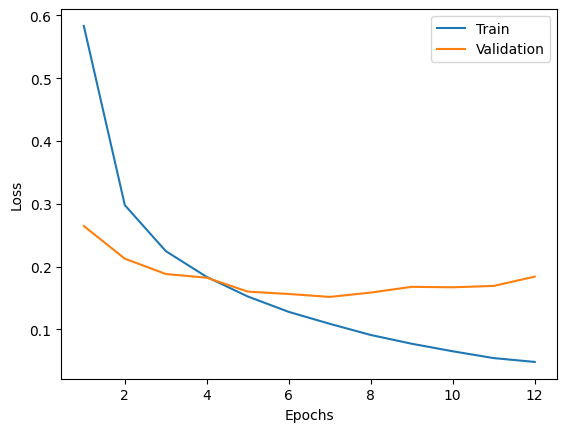

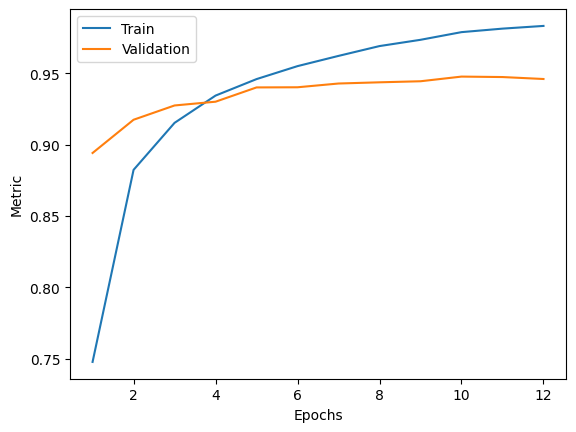

In [41]:
trainer.plot_history()

In [42]:
trainer.best_epoch

7

#Get Accuracy, Predictions

In [44]:
testset = CustomDataset(X_test, y_test)

In [45]:
test_loader = get_test_loaders(testset, batch_size_=hyperparameters.BATCH_SIZE,
                               collate_fn=collate_fn)

In [46]:
# Get the prediction and accuracy for the test dataset

predictions_test, target_test = trainer.predict(
    test_loader, return_targets=True)
predictions_train, target_train = trainer.predict(
    train_loader, return_targets=True)
predictions_valid, target_valid = trainer.predict(
    valid_loader, return_targets=True)


In [50]:
import torchmetrics
metric = torchmetrics.functional.accuracy
acc_train = metric(predictions_train, target_train,
                   task='multiclass', num_classes=10)
acc_valid = metric(predictions_valid, target_valid,
                   task='multiclass', num_classes=10)
acc_test = metric(predictions_test, target_test,
                  task='multiclass', num_classes=10)

In [51]:
# Print Test Accuracy
print('Test accuracy', acc_test * 100)
print('Train accuracy', acc_train * 100)
print('Valid accuracy', acc_valid * 100)

Test accuracy tensor(94.6026)
Train accuracy tensor(99.3604)
Valid accuracy tensor(94.6125)


In [53]:
from sklearn.metrics import accuracy_score, f1_score
print(accuracy_score(predictions_test, target_test)*100)
print(accuracy_score(predictions_train, target_train)*100)
print(accuracy_score(predictions_valid, target_valid)*100)

94.60257221168037
99.36041608096711
94.61254612546125


In [54]:
metric = torchmetrics.functional.f1_score
f1_train = metric(predictions_train, target_train,
                  task='multiclass', num_classes=10)
f1_valid = metric(predictions_valid, target_valid,
                  task='multiclass', num_classes=10)
f1_test = metric(predictions_test, target_test,
                 task='multiclass', num_classes=10)

In [55]:
# Print Test Accuracy
print('Test f1score', f1_test * 100)
print('Train f1score', f1_train * 100)
print('Valid f1score', f1_valid * 100)

Test f1score tensor(94.6026)
Train f1score tensor(99.3604)
Valid f1score tensor(94.6125)


In [56]:
print(f1_score(predictions_test.numpy(), target_test.numpy(), average='micro') * 100)
print(f1_score(predictions_train.numpy(),
      target_train.numpy(), average='micro') * 100)
print(f1_score(predictions_valid.numpy(),
      target_valid.numpy(), average='micro') * 100)

94.60257221168037
99.36041608096711
94.61254612546125
